In [1]:
%matplotlib notebook
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l1
from sklearn.model_selection import train_test_split
import os, glob
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

## Set up parameter variables

In [3]:
epochs = 4
batch_size = 32
l1_val_s = 0.001
l1_val_l = 0.01
dropout_s = 0.1
dropout_l = 0.5

sim_data_path = glob.glob('*_all.npz')[0]
print(sim_data_path)

1D_simulated_data_allCal_6classes_3123198points_domainrand_noisy_all.npz


## Load data

In [4]:
npz_simulated_data = np.load(sim_data_path)

sim_data = npz_simulated_data['x']
sim_labels = npz_simulated_data['y']
phase_names = npz_simulated_data['phases']
phase_names = [s for s in phase_names]
train_data, test_data, train_labels, test_labels = train_test_split(sim_data, sim_labels, random_state=1)
print('train_data & train_labels:')
print(np.shape(train_data), np.shape(train_labels))
print('test_data & test_labels:')
print(np.shape(test_data), np.shape(test_labels))

train_data & train_labels:
(2342398, 182) (2342398,)
test_data & test_labels:
(780800, 182) (780800,)


## Connect to `neptune.io` and start experiment

In [5]:
PARAMS = {
'n_classes': len(phase_names),
'epochs': epochs,
'batch_size': batch_size,
'l1_val_s': l1_val_s,
'l1_val_l': l1_val_l,
'dropout_s': dropout_s,
'dropout_l': dropout_l,
}

tags = ['conv1D', 'noisy', 'bkg'] + phase_names

project_name = 'ml_sed_cambridge/jordi-tests'

# Connect your script to Neptune
import neptune
from neptunecontrib.api.table import log_table
from neptunecontrib.monitoring.keras import NeptuneMonitor
neptune.init(project_qualified_name=project_name,
             api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiZWFhOWRhMjctZGVlNC00MzdjLTkxOGEtN2NlZTA3MjE0ZmEzIn0=',)

# Create experiment
neptune.create_experiment(name=os.path.basename(sim_data_path).split(".")[0],
                          params=PARAMS, tags=tags)


https://ui.neptune.ai/ml_sed_cambridge/jordi-tests/e/JFO-7


Experiment(JFO-7)

## Create Neural Network

In [6]:
# Reshape to create single input variables
train_data = np.reshape(train_data, (train_data.shape[0], train_data.shape[1], 1))
test_data = np.reshape(test_data, (test_data.shape[0],test_data.shape[1], 1))

# Reshape to create categorical labels (instead of value from 0-n, get an n-array with 0s and 1)
from tensorflow.keras.utils import to_categorical
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [7]:
model = Sequential()

l1_val_s = PARAMS['l1_val_s']
l1_val_l = PARAMS['l1_val_l']
n_classes = PARAMS['n_classes']
dropout_s = PARAMS['dropout_s']
dropout_l = PARAMS['dropout_l']
input_shape = (np.shape(test_data)[1], 1)

model.add(tf.keras.layers.Conv1D(32, 8, strides=8, padding='same', input_shape=input_shape, data_format='channels_last', activation='relu'))
model.add(tf.keras.layers.Conv1D(32, 5, activity_regularizer=l1(l1_val_s), strides=5, padding='same', activation='relu'))
model.add(Dropout(dropout_s))
model.add(tf.keras.layers.Conv1D(32, 3, activity_regularizer=l1(l1_val_s), strides=3, padding='same', activation='relu'))
model.add(Dropout(dropout_l))
model.add(tf.keras.layers.Conv1D(32, 3, activity_regularizer=l1(l1_val_l), strides=3, padding='same', activation='relu'))
model.add(Dropout(dropout_s))
model.add(tf.keras.layers.GlobalAveragePooling1D())
model.add(tf.keras.layers.Dense(n_classes,  activation='softmax'))

optimizer = tf.keras.optimizers.Adam()

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, metrics=['accuracy'])

In [8]:
batch_size = PARAMS['batch_size']
epochs =  PARAMS['epochs']
model.fit(train_data, train_labels,
          batch_size=batch_size, epochs=epochs,
          callbacks=[NeptuneMonitor()])

Epoch 1/4
73200/73200 [==============================] - 580s 8ms/step - loss: 0.9426 - accuracy: 0.6540
Epoch 2/4
73200/73200 [==============================] - 578s 8ms/step - loss: 0.8347 - accuracy: 0.7005
Epoch 3/4
73200/73200 [==============================] - 579s 8ms/step - loss: 0.8171 - accuracy: 0.7084
Epoch 4/4
73200/73200 [==============================] - 578s 8ms/step - loss: 0.8098 - accuracy: 0.7113


In [9]:
accuracy_train = model.evaluate(train_data,train_labels,)
accuracy_test = model.evaluate(test_data, test_labels,)

24400/24400 [==============================] - 71s 3ms/step - loss: 0.6705 - accuracy: 0.7786


In [10]:
data = np.vstack([accuracy_train, accuracy_test])
accuracies = pd.DataFrame(data, index=['train', 'test'], columns=['loss', 'accuracy'])
log_table('accuracies', accuracies)
accuracies

,loss,accuracy
train,0.669211,0.779477
test,0.670541,0.778576


In [11]:
name = 'NN_{}classes_{}epochs_{}Train_ac{:.4f}_{}Test{:.4f}.h5'.format(n_classes,
                                                                       epochs,
                                                                       int(test_data.shape[0]/n_classes),
                                                                       accuracy_train[1],
                                                                       int(test_data.shape[0]/n_classes),
                                                                       accuracy_test[1])

model.save(name)
neptune.log_artifact(name)

name_txt = name[:-3] + '_phases.npy'
np.save(name_txt, np.array(phase_names))
neptune.log_artifact(name_txt)

model.summary(print_fn=lambda x: neptune.log_text('model_summary', x))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 23, 32)            288       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 5, 32)             5152      
_________________________________________________________________
dropout (Dropout)            (None, 5, 32)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 2, 32)             3104      
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 32)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1, 32)             3104      
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 32)             0

## Undestanding misclassification in test data

In [12]:
# Get the metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import pandas as pd

preds = np.round(model.predict(test_data), 0)
classification_metrics = metrics.classification_report(test_labels, preds, target_names=phase_names, output_dict=True)
classification_metrics = pd.DataFrame(classification_metrics).T

cf_matrix = confusion_matrix(test_labels.argmax(1), preds.argmax(1),)

<IPython.core.display.Javascript object>


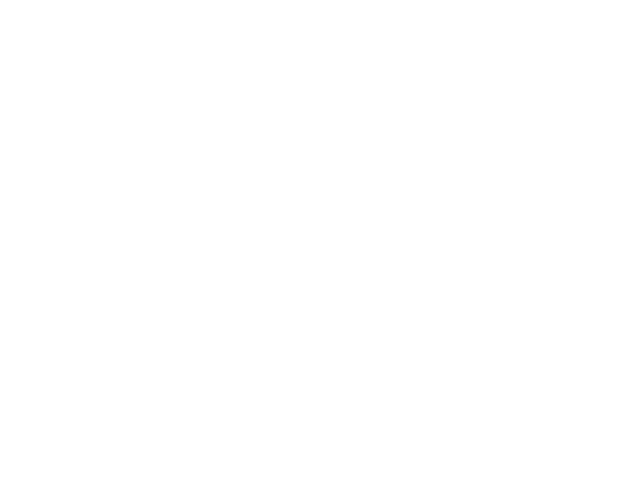

In [13]:
classification_metrics.iloc[:-4,:-1].plot()
fig_class = plt.gcf()
neptune.log_image('classication_matrix', fig_class)

In [14]:
log_table('classification_metrics', classification_metrics)
print(classification_metrics)

                    precision    recall  f1-score   support
cubic_fapbi_scaled   0.861844  0.736542  0.794282  131524.0
pbi2                 0.919786  0.633398  0.750189  131557.0
pbbr2                0.880368  0.584934  0.702869  131319.0
pb                   0.923151  0.752198  0.828953  122824.0
gratia_4h            0.874416  0.521813  0.653591  131620.0
gratia_6h            0.906263  0.650474  0.757354  131956.0
micro avg            0.894129  0.645386  0.749662  780800.0
macro avg            0.894305  0.646560  0.747873  780800.0
weighted avg         0.893992  0.645386  0.746975  780800.0
samples avg          0.645386  0.645386  0.645386  780800.0


In [15]:
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    import itertools
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return plt.gcf()

In [16]:
fig = plot_confusion_matrix(cf_matrix, phase_names, normalize=False)
neptune.log_image('confusion_matrix', fig,)

In [17]:
fig_norm = plot_confusion_matrix(cf_matrix, phase_names, normalize=True)
neptune.log_image('confusion_matrix_norm', fig_norm,)

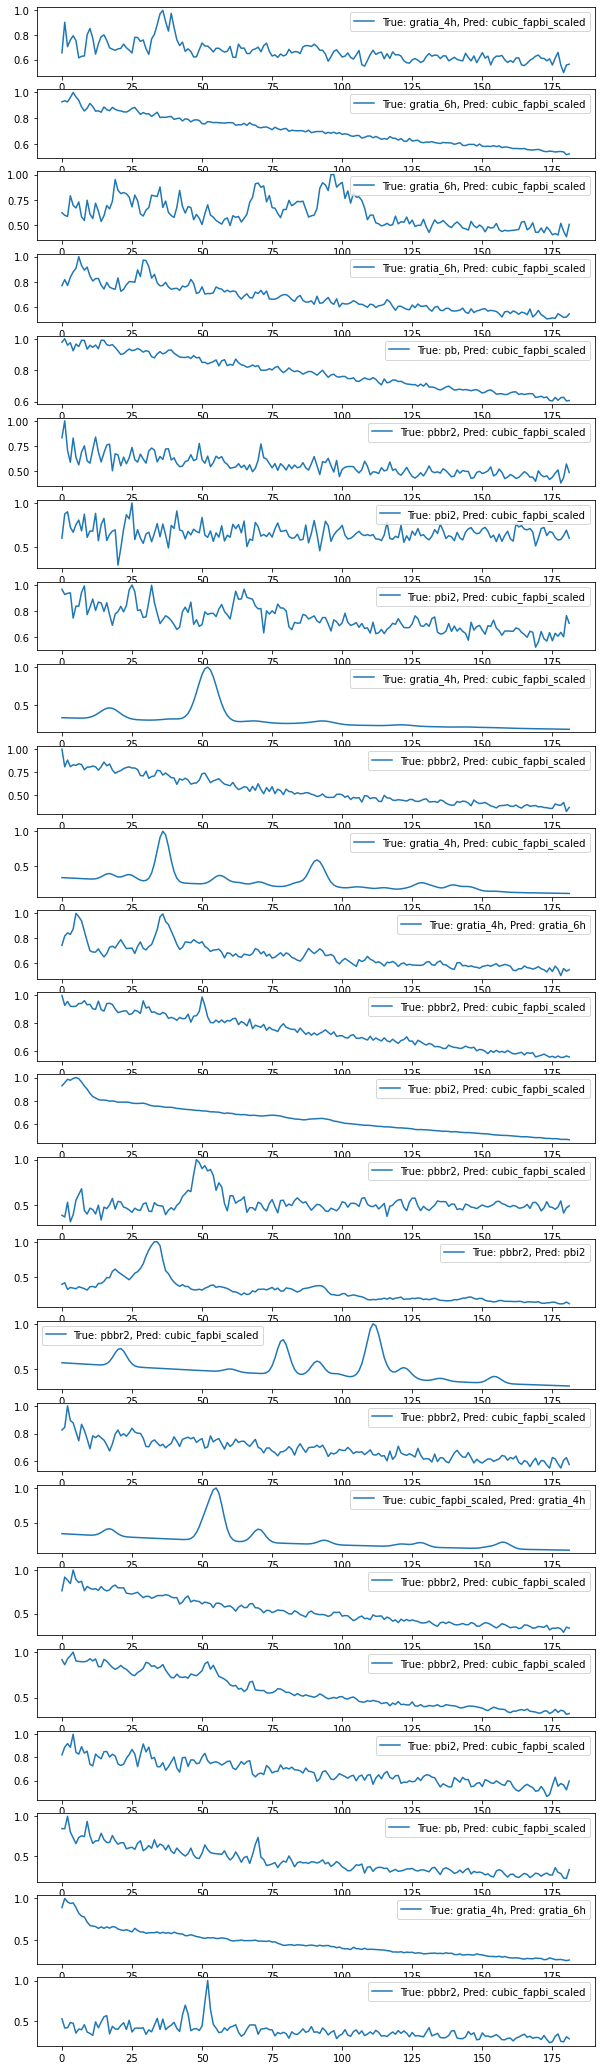

In [18]:
%matplotlib inline
# Plot some of the misclassified data:
bool_predictions = test_labels.argmax(1) == preds.argmax(1)

n_bad = np.count_nonzero(~bool_predictions)
n_max = min(25, n_bad)

fig_pred, axs = plt.subplots(nrows=n_max, figsize = (10, n_max * 1.5))
ax = 0
for i, bool_pred in enumerate(bool_predictions):
    if ax >= n_max:
        break
    if bool_pred == False:
        true_phase = phase_names[test_labels.argmax(1)[i]]
        pred_phase = phase_names[preds.argmax(1)[i]]
        lab = 'True: {}, Pred: {}'.format(true_phase, pred_phase)
        axs[ax].plot(test_data[i,:,0], label=lab)
        axs[ax].legend()
        ax += 1

neptune.log_image('bad_predictions', fig_pred)

In [19]:
neptune.stop()